In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from skimage.util import random_noise

In [2]:
!unrar x /content/ORL.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/ORL.rar

Creating    ORL                                                       OK
Creating    ORL/s1                                                    OK
Extracting  ORL/s1/1.bmp                                                   0%  OK 
Extracting  ORL/s1/10.bmp                                                  0%  OK 
Extracting  ORL/s1/2.bmp                                                   0%  OK 
Extracting  ORL/s1/3.bmp                                                   0%  OK 
Extracting  ORL/s1/4.bmp                                                   1%  OK 
Extracting  ORL/s1/5.bmp                                                   1%  OK 
Extracting  ORL/s1/6.bmp                                                   1%  OK 
Extracting  ORL/s1/7.bmp                                                   1%  OK 
Extracti

In [3]:
DATA_PATH = 'ORL'

In [4]:
IMAGE_SIZE = (64, 64)  # Resize dimensions
NUM_CLASSES = 40  # Number of individuals
TRAIN_IMAGES = 7  # Number of training images per person
TEST_IMAGES = 3   # Number of testing images per person

In [5]:
def load_data():
    X_train, X_test, y_train, y_test = [], [], [], []

    for label in range(1, NUM_CLASSES + 1):
        person_folder = os.path.join(DATA_PATH, f's{label}')

        for i, filename in enumerate(sorted(os.listdir(person_folder))):
          if 'bmp' in filename:
            image_path = os.path.join(person_folder, filename)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, IMAGE_SIZE).flatten()

            if i < TRAIN_IMAGES:
                X_train.append(img)
                y_train.append(label)
            else:
                X_test.append(img)
                y_test.append(label)

    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [6]:
# Load the data
X_train, X_test, y_train, y_test = load_data()

In [7]:
import matplotlib.pyplot as plt

def show_images(X_train, y_train):
  fig, axes = plt.subplots(3, 10, figsize=(10, 3))

  for person_label in range(1, 10 + 1):
      person_images = []
      for i, (image, label) in enumerate(zip(X_train, y_train)):
          if label == person_label and len(person_images) < 3:
              person_images.append(image)
              if len(person_images) == 3:
                  break

      for i in range(3):
          if i < len(person_images):
              image = person_images[i].reshape(IMAGE_SIZE)
              axes[i, person_label - 1].imshow(image, cmap='gray')
              axes[i, person_label - 1].axis('off')

  plt.tight_layout()
  plt.show()

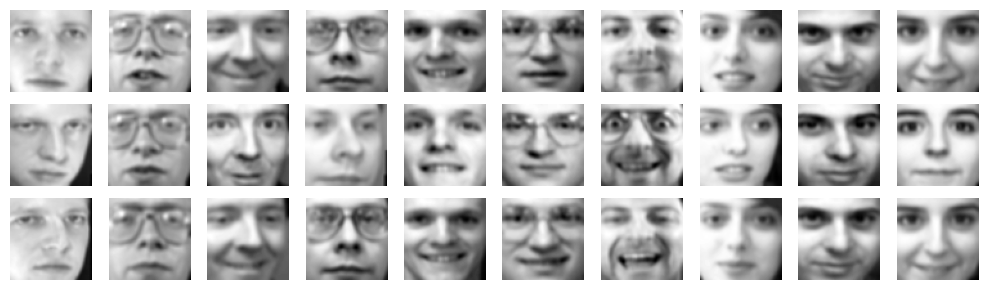

In [8]:
show_images(X_train, y_train)

In [9]:
import cv2
import numpy as np

def enhance_contrast(images, image_size):
    enhanced_images = []
    for image in images:
        # Reshape, apply histogram equalization, then flatten back to original format
        reshaped_image = image.reshape(image_size).astype(np.uint8)
        enhanced_image = cv2.equalizeHist(reshaped_image)
        enhanced_images.append(enhanced_image.flatten())

    return np.array(enhanced_images)

X_train_enhanced = enhance_contrast(X_train, IMAGE_SIZE)
X_test_enhanced = enhance_contrast(X_test, IMAGE_SIZE)

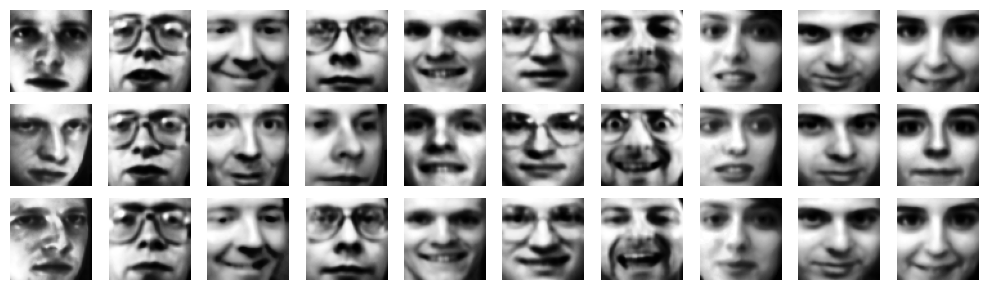

In [10]:
show_images(X_train_enhanced, y_train)

## PCA

In [11]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_enhanced)
X_test_pca = pca.transform(X_test_enhanced)

In [12]:
import tqdm
from tqdm import tqdm

hidden_layer_sizes = range(100, 2000, 10)
best_accuracy = 0
best_neurons = 0

accuracies = []

for neurons in tqdm(hidden_layer_sizes):
    mlp = MLPClassifier(hidden_layer_sizes=(neurons,), activation='relu', solver='adam', learning_rate_init=0.01, max_iter=100)
    mlp.fit(X_train_pca, y_train)
    y_pred = mlp.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_neurons = neurons


  6%|▌         | 11/190 [00:10<03:16,  1.10s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
 34%|███▎      | 64/190 [01:04<01:38,  1.28it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
 67%|██████▋   | 128/190 [02:32<01:33,  1.50s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
 84%|████████▎ | 159/190 [03:31<01:16,  2.48s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stoch

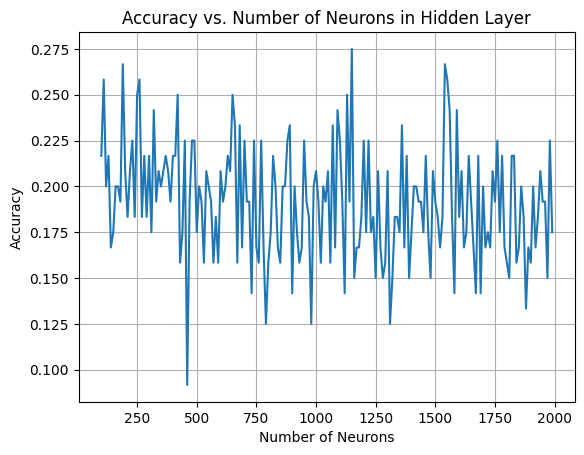

In [13]:
plt.plot(hidden_layer_sizes, accuracies)
plt.xlabel("Number of Neurons")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Neurons in Hidden Layer")
plt.grid(True)
plt.show()

In [14]:
print(f"Best accuracy achieved with {best_neurons} neurons: {best_accuracy}")

Best accuracy achieved with 1150 neurons: 0.275


In [15]:
num_pcs = range(3, 100, 1)
pcs_accuracies = []
best_accuracy = 0
best_pcs = 0

for i in tqdm(num_pcs):
    pca = PCA(n_components=i)
    X_train_pca2 = pca.fit_transform(X_train_enhanced)
    X_test_pca2 = pca.transform(X_test_enhanced)
    mlp = MLPClassifier(hidden_layer_sizes=(best_neurons, 40),
                        activation='relu',
                        solver='adam',
                        learning_rate_init=0.01,
                        max_iter=100)

    mlp.fit(X_train_pca2, y_train)
    y_pred = mlp.predict(X_test_pca2)
    accuracy = accuracy_score(y_test, y_pred)
    pcs_accuracies.append(accuracy)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_pcs = i

  6%|▌         | 6/97 [00:05<01:32,  1.01s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
  8%|▊         | 8/97 [00:08<01:33,  1.05s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
  9%|▉         | 9/97 [00:10<02:09,  1.47s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
 16%|█▋        | 16/97 [00:17<01:03,  1.27it/s]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Opt

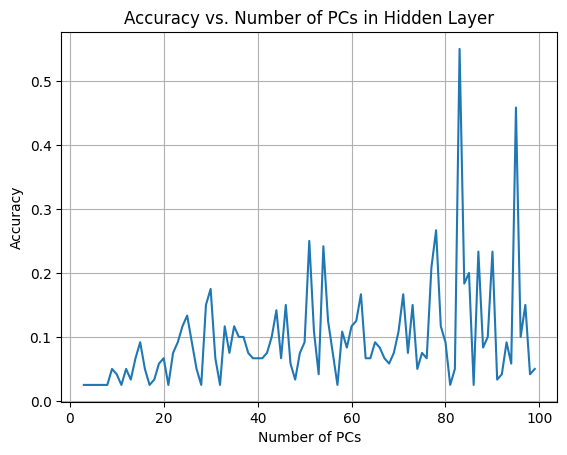

In [16]:
plt.plot(num_pcs, pcs_accuracies)
plt.xlabel("Number of PCs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of PCs in Hidden Layer")
plt.grid(True)
plt.show()

based on this curve we understand

In [17]:
print(f"Best accuracy achieved with {best_pcs} number of PC and {best_neurons} neuron: {best_accuracy}")

Best accuracy achieved with 83 number of PC and 1150 neuron: 0.55


In [18]:
pca = PCA(n_components=best_pcs)
X_train_pca_best= pca.fit_transform(X_train_enhanced)
X_test_pca_best = pca.transform(X_test_enhanced)

In [19]:
second_hidden_layer_neurons = range(10, best_neurons, 10)
second_layer_accuracies = []

for second_layer_neurons_count in tqdm(second_hidden_layer_neurons):
    mlp = MLPClassifier(hidden_layer_sizes=(best_neurons, second_layer_neurons_count),
                        activation='relu',
                        solver='adam',
                        learning_rate_init=0.01,
                        max_iter=100)

    mlp.fit(X_train_pca_best, y_train)
    y_pred = mlp.predict(X_test_pca_best)
    accuracy = accuracy_score(y_test, y_pred)
    second_layer_accuracies.append(accuracy)

  2%|▏         | 2/114 [00:04<04:17,  2.30s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
  5%|▌         | 6/114 [00:12<03:51,  2.14s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
  7%|▋         | 8/114 [00:24<06:56,  3.93s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
 11%|█         | 12/114 [00:36<04:30,  2.65s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic

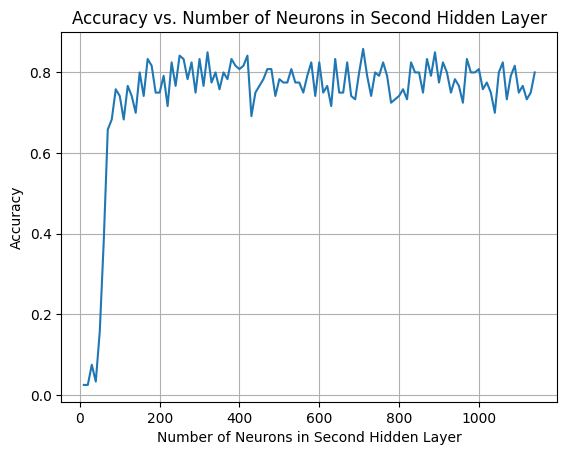

In [20]:
plt.plot(second_hidden_layer_neurons, second_layer_accuracies)
plt.xlabel("Number of Neurons in Second Hidden Layer")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Neurons in Second Hidden Layer")
plt.grid(True)
plt.show()

In [21]:
best_second_layer_accuracy = 0
best_second_layer_neurons = 0

for i, accuracy in enumerate(second_layer_accuracies):
    if accuracy > best_second_layer_accuracy:
        best_second_layer_accuracy = accuracy
        best_second_layer_neurons = second_hidden_layer_neurons[i]

print(f"Best accuracy achieved with {best_second_layer_neurons} neurons in the second hidden layer: {best_second_layer_accuracy}")


Best accuracy achieved with 710 neurons in the second hidden layer: 0.8583333333333333


In [22]:
first_hidden_layer_neurons = range(best_second_layer_neurons, 2000, 10)
first_layer_accuracies = []
best_first_layer_accuracy = 0
best_first_layer_neurons = 0

for first_layer_neurons_count in tqdm(first_hidden_layer_neurons):
    mlp = MLPClassifier(hidden_layer_sizes=(first_layer_neurons_count, best_second_layer_neurons),
                        activation='relu',
                        solver='adam',
                        learning_rate_init=0.01,
                        max_iter=100)

    mlp.fit(X_train_pca_best, y_train)
    y_pred = mlp.predict(X_test_pca_best)
    accuracy = accuracy_score(y_test, y_pred)
    first_layer_accuracies.append(accuracy)

    if accuracy > best_first_layer_accuracy:
        best_first_layer_accuracy = accuracy
        best_first_layer_neurons = first_layer_neurons_count


 84%|████████▎ | 108/129 [09:18<02:22,  6.80s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 129/129 [12:07<00:00,  5.64s/it]


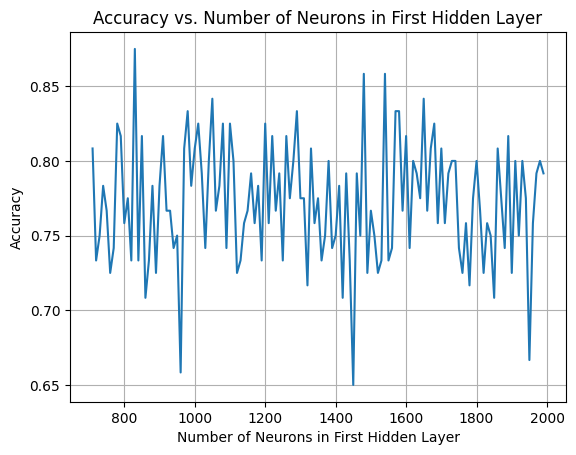

In [23]:
plt.plot(first_hidden_layer_neurons, first_layer_accuracies)
plt.xlabel("Number of Neurons in First Hidden Layer")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Neurons in First Hidden Layer")
plt.grid(True)
plt.show()

In [24]:
print(f"Best accuracy achieved with {best_first_layer_neurons} neurons in the first hidden layer: {best_first_layer_accuracy}")

Best accuracy achieved with 830 neurons in the first hidden layer: 0.875


In [25]:
best_accuracy = 0
best_mlp = None

for i in tqdm(range(100)):
  test_mlp = MLPClassifier(hidden_layer_sizes=(best_first_layer_neurons, best_second_layer_neurons),
                          activation='relu',
                          solver='adam',
                          learning_rate_init=0.01,
                          max_iter=100)

  test_mlp.fit(X_train_pca_best, y_train)
  y_pred = test_mlp.predict(X_test_pca_best)
  accuracy = accuracy_score(y_test, y_pred)
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_mlp = test_mlp

 30%|███       | 30/100 [01:50<04:14,  3.64s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
 54%|█████▍    | 54/100 [03:20<02:20,  3.05s/it]/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 100/100 [06:14<00:00,  3.75s/it]


In [26]:
print(f"Best accuracy achieved on the test set: {best_accuracy}")

Best accuracy achieved on the test set: 0.8583333333333333


In [27]:
y_pred = best_mlp.predict(X_test_pca_best)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Accuracy on the test set: {accuracy}")

Best Accuracy on the test set: 0.8583333333333333


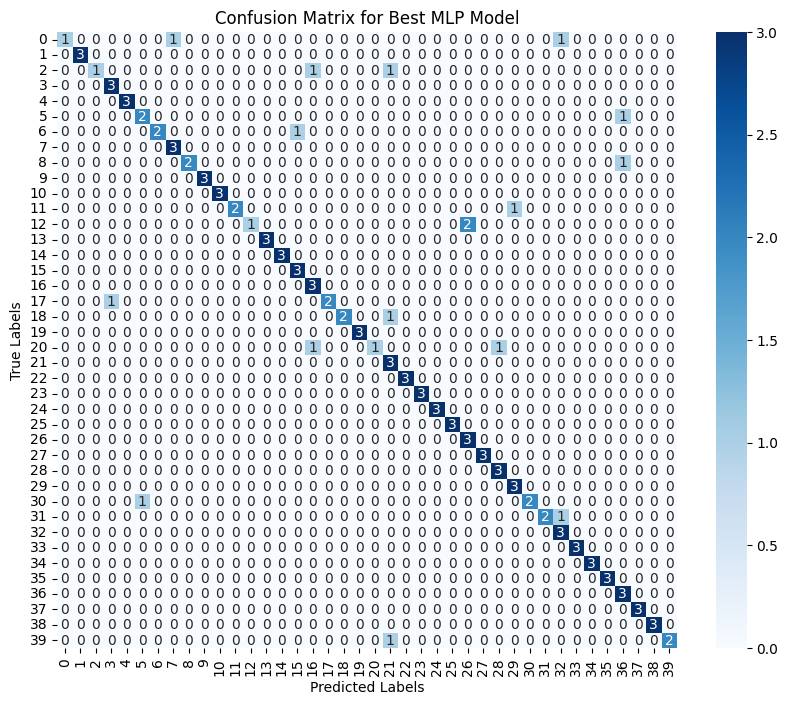

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Best MLP Model")
plt.show()

In [29]:
print(f"best number of neurons in first hidden layer: {best_first_layer_neurons}")
print(f"best number of neurons in second hidden layer: {best_second_layer_neurons}")
print(f"best number of PCs: {best_pcs}")

best number of neurons in first hidden layer: 830
best number of neurons in second hidden layer: 710
best number of PCs: 83


## Robustness

### Salt Pepper Noise

In [36]:
def add_salt_pepper_noise(images, probability):
    noisy_images = []
    for image in images:
        noisy_image = random_noise(image.reshape(IMAGE_SIZE), mode='s&p', amount=probability)
        noisy_images.append(noisy_image.flatten())
    return np.array(noisy_images)


noise_probabilities = 0.05

X_train_noisy = add_salt_pepper_noise(X_train_enhanced, noise_probabilities)
X_test_noisy = add_salt_pepper_noise(X_test_enhanced, noise_probabilities)


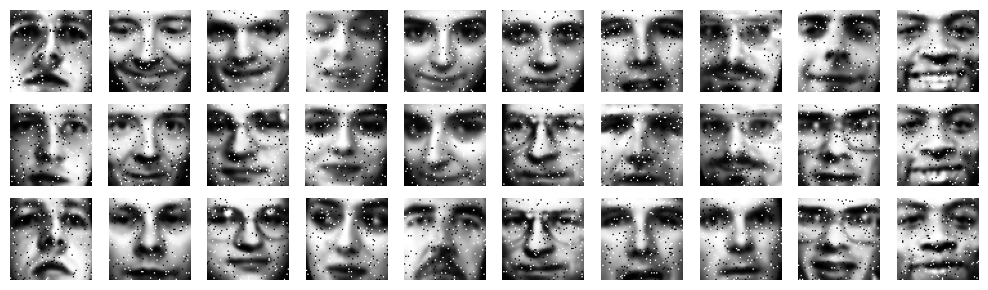

In [45]:
show_images(X_test_noisy, y_train)

In [38]:
pca = PCA(n_components=best_pcs)
X_train_pca_noisy = pca.fit_transform(X_train_noisy)
X_test_pca_noisy = pca.transform(X_test_noisy)

y_pred = best_mlp.predict(X_test_pca_noisy)
accuracy = accuracy_score(y_test, y_pred)

In [39]:
print(f"Accuracy with {noise_prob} noise probability: {accuracy}")

Accuracy with 0.2 noise probability: 0.38333333333333336


### Rotation

In [63]:
def rotate_images(images, angle):
    rotated_images = []
    for image in images:
        reshaped_image = image.reshape(IMAGE_SIZE)
        rows, cols = reshaped_image.shape
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), np.random.uniform(-angle,angle), 1)
        rotated_image = cv2.warpAffine(reshaped_image, rotation_matrix, (cols, rows))
        rotated_images.append(rotated_image.flatten())
    return np.array(rotated_images)

rotation_angles = 30

X_train_rotated = rotate_images(X_train_enhanced, rotation_angles)
X_test_rotated = rotate_images(X_test_enhanced, rotation_angles)

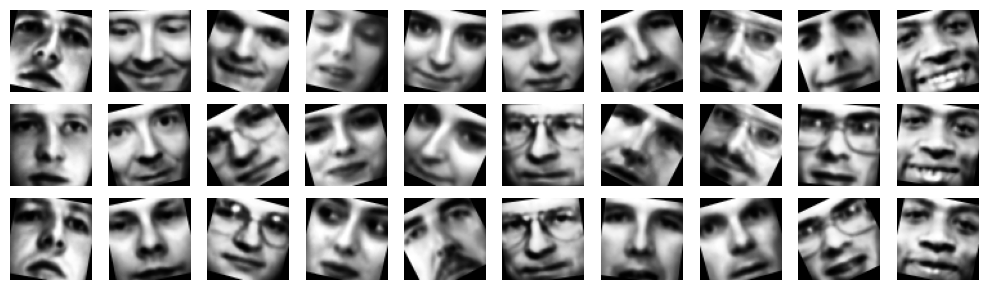

In [64]:
show_images(X_test_rotated, y_train)

In [65]:
pca = PCA(n_components=best_pcs)
X_train_pca_rotated = pca.fit_transform(X_train_rotated)
X_test_pca_rotated = pca.transform(X_test_rotated)


y_pred_rotated = best_mlp.predict(X_test_pca_rotated)
accuracy_rotated = accuracy_score(y_test, y_pred_rotated)

In [66]:
print(f"Accuracy with {rotation_angles} degree rotation: {accuracy_rotated}")

Accuracy with 30 degree rotation: 0.03333333333333333
